In [1]:
!pip install transformers -qU
!pip install datasets -qU
!pip install pytorch-lightning -qU

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 30.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.3/519.3 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 722.8/722.8 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 15.3 MB/s eta 0:00:00


In [2]:
import re
import time
from typing import List, Optional, Tuple
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch

import torch.nn as nn
import torch.nn.functional as F

from torch.nn import ConstantPad1d, Linear, CrossEntropyLoss, ReLU, Softmax, Dropout, Sequential
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler,random_split
from pytorch_lightning import LightningDataModule, LightningModule, Trainer
from pytorch_lightning.callbacks import EarlyStopping

from transformers import AutoModel, AutoTokenizer


import warnings
warnings.filterwarnings(action="ignore")

pd.set_option('display.max_colwidth', 3000)
pd.set_option('display.max_columns', None)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
df = pd.read_csv("data/train.csv")

labels_mapping = {0: "entailment", 1: "neutral", 2: "contradiction"}
ids_to_language = {i: language for i, language in enumerate(df["language"].unique())}
language2ids = {language: i for i, language in ids_to_language.items()}

df['premise']  = df['premise'].apply(lambda x: x.lower())
df['hypothesis']  = df['hypothesis'].apply(lambda x: x.lower())
df['language_id'] = df["language"].map(language2ids)
df['label_name'] = df["label"].map(labels_mapping)
df.drop(["id", "lang_abv"], axis=1, inplace=True)
df.head()

Mounted at /content/drive


,premise,hypothesis,language,label,language_id,label_name
0,and these comments were considered in formulating the interim rules.,the rules developed in the interim were put together with these comments in mind.,English,0,0,entailment
1,"these are issues that we wrestle with in practice groups of law firms, she said.",practice groups are not permitted to work on these issues.,English,2,0,contradiction
2,des petites choses comme celles-là font une différence énorme dans ce que j'essaye de faire.,j'essayais d'accomplir quelque chose.,French,0,1,entailment
3,you know they can't really defend themselves like somebody grown uh say my age you know yeah,they can't defend themselves because of their age.,English,0,0,entailment
4,ในการเล่นบทบาทสมมุติก็เช่นกัน โอกาสที่จะได้แสดงออกและได้เล่นหลายบทบาทไปพร้อมกัน ๆ อาจช่วยให้เด็กจับความคล้ายคลึงและความแตกต่างระหว่างผู้คนในด้านความปรารถนา ความเชื่อ และความรู้สึกได้,เด็กสามารถเห็นได้ว่าชาติพันธุ์แตกต่างกันอย่างไร,Thai,1,2,neutral


# Data Overview

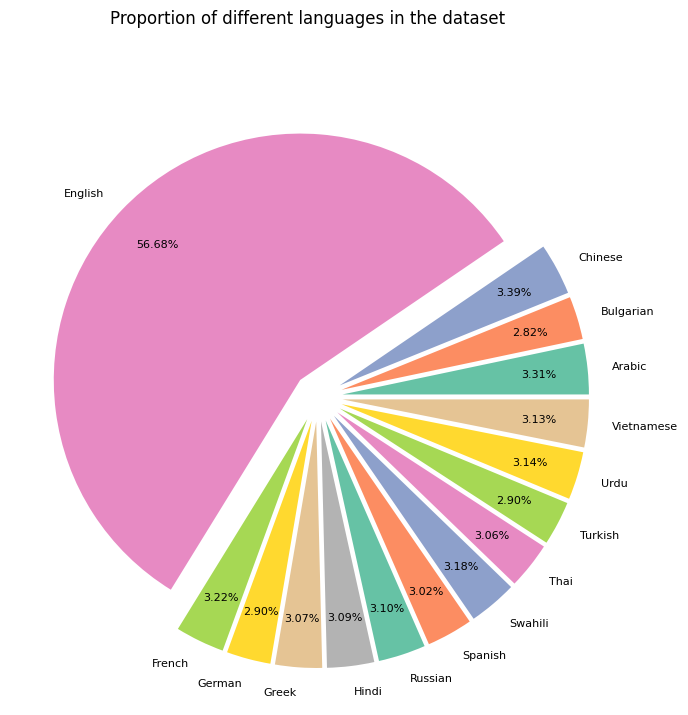

In [4]:
df_stats = df.groupby("language").agg(count=("premise", 'count')).reset_index()

fig, ax = plt.subplots(figsize=(8,8))
fig.suptitle("Proportion of different languages in the dataset")
ax.pie(df_stats["count"], labels=df_stats["language"],
       autopct='%1.2f%%',
       explode= [0.1]*len(df_stats),
       textprops={'fontsize': 8},
       labeldistance=1.1,
       pctdistance=0.8,
       colors=sns.color_palette('Set2'))
fig.show()


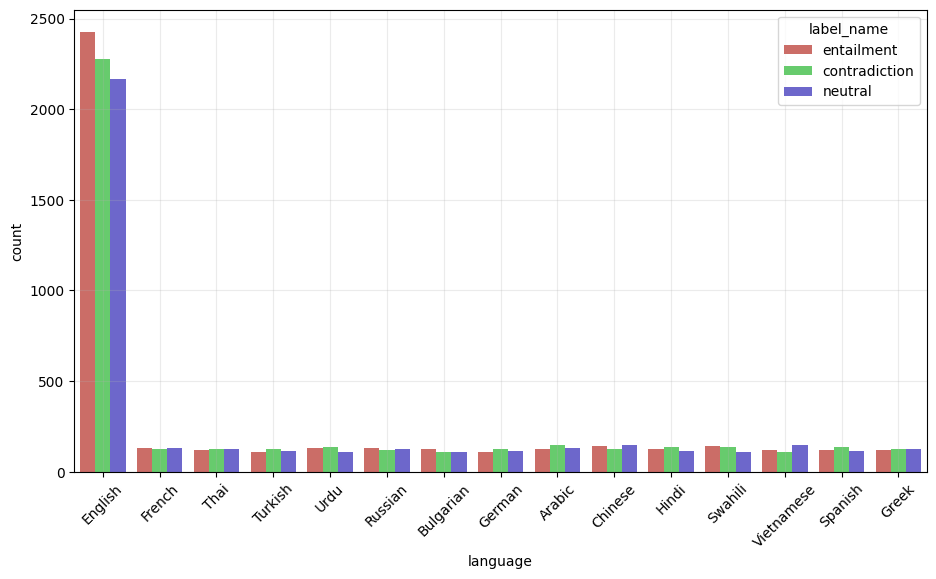

In [5]:
fig, ax = plt.subplots(figsize=(11,6))
sns.countplot(data=df, x="language", hue="label_name", palette="hls", ax=ax)
ax.grid(alpha=0.25)
ax.tick_params(axis='x', rotation=45)

# Tokenizer & Model


In [6]:
model_name_or_path = 'symanto/xlm-roberta-base-snli-mnli-anli-xnli'
#model_name_or_path = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, do_lower_case=True)
tokenizer.special_tokens_map

{'bos_token': '<s>',
 'eos_token': '</s>',
 'unk_token': '<unk>',
 'sep_token': '</s>',
 'pad_token': '<pad>',
 'cls_token': '<s>',
 'mask_token': '<mask>'}

# Dataset

In [7]:
class CustomDataset(Dataset):

    def __init__(self, df, tokenizer):
        super().__init__()
        self.tokenizer = tokenizer
        self.inputs_1 = df["premise"].values
        self.inputs_2 = df["hypothesis"].values
        self.labels = torch.tensor(df["label"].values).to(torch.int64)
        self.language = torch.tensor(df["language_id"].values).to(torch.int64)

    def __getitem__(self, idx):
        encoded_dict = tokenizer(self.inputs_1[idx],
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        input_ids_1 = encoded_dict['input_ids'][0]
        attention_mask_1 = encoded_dict['attention_mask'][0]

        encoded_dict = tokenizer(self.inputs_2[idx],
                                 add_special_tokens = True,
                                 return_attention_mask = True,
                                 return_tensors = 'pt',
                   )
        input_ids_2 = encoded_dict['input_ids'][0]
        attention_mask_2 = encoded_dict['attention_mask'][0]

        return input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, self.labels[idx], self.language[idx]

    def __len__(self):
        return len(self.labels)

In [8]:
dataset = CustomDataset(df, tokenizer)
train_size = int(0.8 * len(dataset))
validation_size = len(dataset)  - train_size
train_dataset, validation_dataset = random_split(dataset, [train_size, validation_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(validation_size))

9,696 training samples
2,424 validation samples


# Dataloaders

In [9]:
def padding_function(x, max_len):
    return ConstantPad1d((0, max_len - len(x)), 0)(x)

def collate_fn(batch):

    max_len_1 = max([len(sample[0]) for sample in batch])
    max_len_2 = max([len(sample[2]) for sample in batch])

    input_ids_1 = torch.stack([padding_function(sample[0], max_len_1) for sample in batch]).to(device)
    attention_masks_1 = torch.stack([padding_function(sample[1], max_len_1) for sample in batch]).to(device)
    input_ids_2 = torch.stack([padding_function(sample[2], max_len_2) for sample in batch]).to(device)
    attention_masks_2 = torch.stack([padding_function(sample[3], max_len_2) for sample in batch]).to(device)
    labels = torch.tensor([sample[4] for sample in batch]).to(device)
    language = torch.tensor([sample[5] for sample in batch]).to(device)

    return input_ids_1, attention_masks_1, input_ids_2, attention_masks_2, labels, language


In [10]:
batch_size = 16

train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

validation_dataloader = DataLoader(
            validation_dataset,
            sampler = SequentialSampler(validation_dataset),
            batch_size = batch_size,
            collate_fn=collate_fn
        )

# Model

In [11]:
class ClassificationModel(LightningModule):
    def __init__(
        self,
        model_name_or_path: str,
        model_dim: int,
        hidden_dim: int,
        num_labels: int,
        learning_rate: float = 2e-5,
        adam_epsilon: float = 1e-8,
    ):
        super().__init__()

        self.save_hyperparameters()
        self.learning_rate = learning_rate
        self.adam_epsilon = adam_epsilon

        self.encoder = AutoModel.from_pretrained(model_name_or_path)
        self.fc = Sequential(
            Linear(model_dim*2, hidden_dim),
            ReLU(),
            Dropout(p=0.1),
            Linear(hidden_dim, num_labels),
            Softmax(),
            Dropout(p=0.1),
        )
        self.loss = CrossEntropyLoss()
        self.validation_step_outputs = []

    def forward(self, input_ids_1, attention_mask_1, input_ids_2, attention_mask_2):
        x1 = self.encoder(input_ids=input_ids_1, attention_mask=attention_mask_1).pooler_output
        x2 = self.encoder(input_ids=input_ids_2, attention_mask=attention_mask_2).pooler_output
        return self.fc(torch.cat((x1, x2), 1))

    def step(self, batch):
        input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, labels, _ = batch
        logits = self(input_ids_1, attention_mask_1, input_ids_2, attention_mask_2)
        loss = self.loss(logits, labels)
        return loss, logits

    def training_step(self, batch, batch_idx):
        loss, _ = self.step(batch)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        loss, logits = self.step(batch)
        predictions = torch.argmax(logits, dim=1)
        self.validation_step_outputs.append({"loss": loss, "predictions": predictions, "labels": batch[4]})


    def on_validation_epoch_end(self):

        outputs = self.validation_step_outputs
        predictions = torch.cat([x["predictions"] for x in outputs]).detach().cpu().numpy()
        labels = torch.cat([x["labels"] for x in outputs]).detach().cpu().numpy()
        loss = torch.stack([x["loss"] for x in outputs]).mean()

        self.log("validation_loss", loss, prog_bar=True)
        self.log("validation_accuracy", (labels==predictions).sum()/len(predictions), prog_bar=True)
        print("\n\nValidaiton Accuracy", (labels==predictions).sum()/len(predictions) )

        self.validation_step_outputs.clear()



    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate, eps=self.adam_epsilon)
        return optimizer

    def save_pretrained(self, savefile):
        self.encoder.save_pretrained(savefile)


In [12]:
epochs = 5
learning_rate = 2e-5
adam_epsilon = 1e-7

early_stopping = EarlyStopping(monitor="validation_loss", mode="min", patience=3)

model = ClassificationModel(model_name_or_path, model_dim=768, hidden_dim = 50, num_labels=3)
trainer = Trainer(accelerator="gpu", max_epochs=epochs, callbacks=[early_stopping])
trainer.fit(model, train_dataloader, validation_dataloader)

Some weights of XLMRobertaModel were not initialized from the model checkpoint at symanto/xlm-roberta-base-snli-mnli-anli-xnli and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type             | Params
---------------------------------------------
0 | encoder | XLMRobertaModel  | 278 M 
1 | fc      | Sequential       | 77.0 K
2 | loss    | CrossEntropyLoss | 0     
-------------

Sanity Checking: 0it [00:00, ?it/s]



Validaiton Accuracy 0.40625


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]



Validaiton Accuracy 0.5787953795379538


Validation: 0it [00:00, ?it/s]



Validaiton Accuracy 0.5808580858085809


Validation: 0it [00:00, ?it/s]



Validaiton Accuracy 0.5952970297029703


Validation: 0it [00:00, ?it/s]



Validaiton Accuracy 0.5903465346534653


Validation: 0it [00:00, ?it/s]



Validaiton Accuracy 0.5771452145214522


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


In [ ]:
from pytorch_lightning.tuner import Tuner

epochs = 12
learning_rate = 1e-5
adam_epsilon = 1e-7
weight_decay = 0.005


model = ClassificationModel(model_name_or_path, model_dim=768, hidden_dim = 50, num_labels=3)

trainer = Trainer(accelerator="gpu", max_epochs=epochs)

tuner = Tuner(trainer)
lr_finder = tuner.lr_find(model,
                          attr_name="learning_rate",
                          train_dataloaders=train_dataloader,
                          val_dataloaders=validation_dataloader,
                          min_lr=5e-6,
                          max_lr=5e-4,
                          early_stop_threshold=None
                        )


# Plot with
fig = lr_finder.plot(suggest=True)
fig.show()

# Results can be found in
#lr_finder.results


# Evaluate

In [14]:
from sklearn.metrics import confusion_matrix

def evaluate(dataloader):

    true_labels = []
    predicted_labels = []
    language = []

    for i, batch in enumerate(dataloader):

        input_ids_1, attention_mask_1, input_ids_2, attention_mask_2, labels, lang = batch
        model.to(device)

        output = model( input_ids_1, attention_mask_1, input_ids_2, attention_mask_2)
        true_labels.append(labels.to('cpu').numpy())
        language.append(lang.to('cpu').numpy())
        predicted_labels.append(torch.argmax(output.detach().cpu(), 1).numpy())

    true_labels = np.hstack(true_labels)
    predicted_labels = np.hstack(predicted_labels)
    language = np.hstack(language)

    res_df = pd.DataFrame({"TrueLabel": true_labels, "PredictedLabel": predicted_labels, "LanguageId": language})
    res_df["Language"] = res_df["LanguageId"].map(ids_to_language)
    res_df["CorrectPrediction"] = (res_df["TrueLabel"] == res_df["PredictedLabel"])
    res_df = res_df.groupby("Language")["CorrectPrediction"].agg(CorrectPredictions="sum", AllPredictions="count")
    res_df["Accuracy"] = round(res_df['CorrectPredictions']/res_df["AllPredictions"], 2)
    res_dict = res_df["Accuracy"].to_dict()
    res_dict["Average"] = sum(true_labels==predicted_labels)/len(true_labels)
    res_dict["NumberOfSamples"] = len(true_labels)

    print(res_dict)
    cm = confusion_matrix(true_labels, predicted_labels, labels=[0,1,2], normalize='true')
    ax= plt.subplot()
    sns.heatmap(np.round(cm, 2), annot=True, fmt='g', ax=ax, cmap='cool')
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(["entailment", "neutral", "contradiction"])
    ax.yaxis.set_ticklabels(["entailment", "neutral", "contradiction"])
    plt.show()

    return res_dict

{'Arabic': 0.75, 'Bulgarian': 0.8, 'Chinese': 0.74, 'English': 0.69, 'French': 0.78, 'German': 0.77, 'Greek': 0.77, 'Hindi': 0.76, 'Russian': 0.77, 'Spanish': 0.78, 'Swahili': 0.68, 'Thai': 0.75, 'Turkish': 0.74, 'Urdu': 0.73, 'Vietnamese': 0.76, 'Average': 0.7211221122112211, 'NumberOfSamples': 9696}


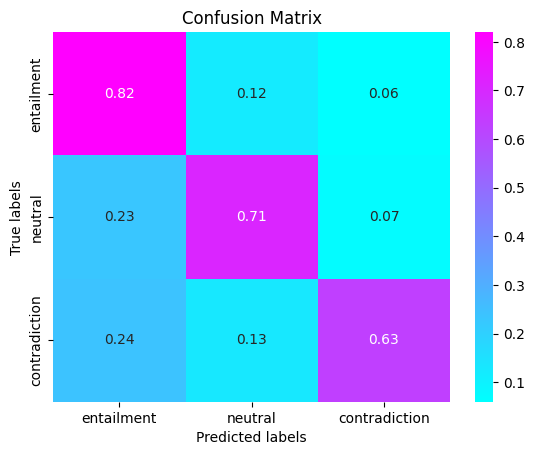

{'Arabic': 0.75,
 'Bulgarian': 0.8,
 'Chinese': 0.74,
 'English': 0.69,
 'French': 0.78,
 'German': 0.77,
 'Greek': 0.77,
 'Hindi': 0.76,
 'Russian': 0.77,
 'Spanish': 0.78,
 'Swahili': 0.68,
 'Thai': 0.75,
 'Turkish': 0.74,
 'Urdu': 0.73,
 'Vietnamese': 0.76,
 'Average': 0.7211221122112211,
 'NumberOfSamples': 9696}

In [15]:
evaluate(train_dataloader)

{'Arabic': 0.63, 'Bulgarian': 0.63, 'Chinese': 0.51, 'English': 0.49, 'French': 0.53, 'German': 0.53, 'Greek': 0.61, 'Hindi': 0.55, 'Russian': 0.66, 'Spanish': 0.58, 'Swahili': 0.73, 'Thai': 0.65, 'Turkish': 0.58, 'Urdu': 0.61, 'Vietnamese': 0.57, 'Average': 0.5354785478547854, 'NumberOfSamples': 2424}


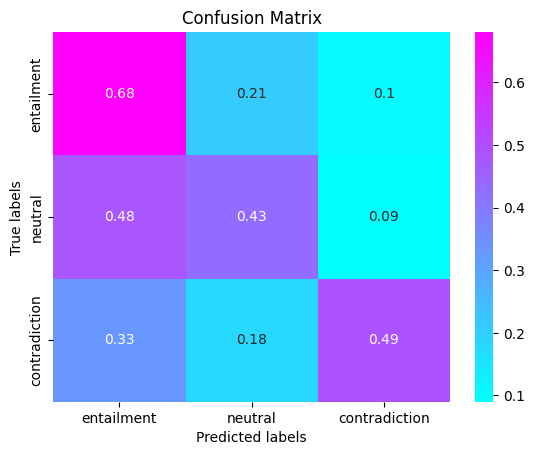

{'Arabic': 0.63,
 'Bulgarian': 0.63,
 'Chinese': 0.51,
 'English': 0.49,
 'French': 0.53,
 'German': 0.53,
 'Greek': 0.61,
 'Hindi': 0.55,
 'Russian': 0.66,
 'Spanish': 0.58,
 'Swahili': 0.73,
 'Thai': 0.65,
 'Turkish': 0.58,
 'Urdu': 0.61,
 'Vietnamese': 0.57,
 'Average': 0.5354785478547854,
 'NumberOfSamples': 2424}

In [16]:
evaluate(validation_dataloader)

{'Arabic': 0.55, 'Bulgarian': 0.5, 'Chinese': 0.63, 'English': 0.51, 'French': 0.46, 'German': 0.52, 'Greek': 0.62, 'Hindi': 0.51, 'Russian': 0.62, 'Spanish': 0.59, 'Swahili': 0.64, 'Thai': 0.54, 'Turkish': 0.54, 'Urdu': 0.62, 'Vietnamese': 0.61, 'Average': 0.5363036303630363, 'NumberOfSamples': 2424}


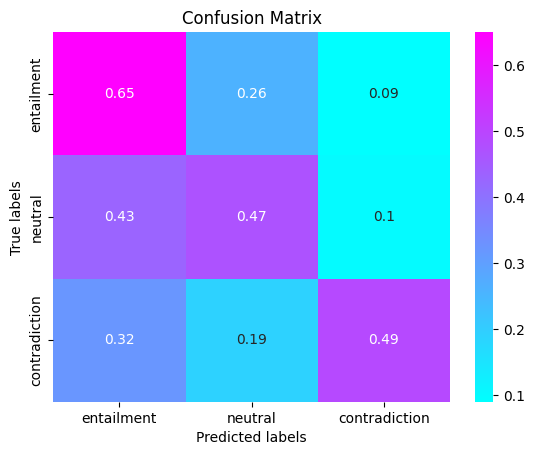

{'Arabic': 0.55,
 'Bulgarian': 0.5,
 'Chinese': 0.63,
 'English': 0.51,
 'French': 0.46,
 'German': 0.52,
 'Greek': 0.62,
 'Hindi': 0.51,
 'Russian': 0.62,
 'Spanish': 0.59,
 'Swahili': 0.64,
 'Thai': 0.54,
 'Turkish': 0.54,
 'Urdu': 0.62,
 'Vietnamese': 0.61,
 'Average': 0.5363036303630363,
 'NumberOfSamples': 2424}

In [17]:
evaluate(validation_dataloader)

# Save pretrained model

In [18]:
model.save_pretrained("classification_model")
tokenizer.save_pretrained("tokenizer")

('tokenizer/tokenizer_config.json',
 'tokenizer/special_tokens_map.json',
 'tokenizer/tokenizer.json')